In [1]:
"""
Social Hypergraph AutoEncode Framework for Social Relationship Inference

"""
# 为了方便GAT训练，这里把用户的id都-1，让id从0开始
import pickle
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling, to_undirected
import heapq
import random
from GATmodel import GATNet
from torch_geometric.data import Data

# 转换lable
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

# 读取数据
def get_data(city):
    with open('data_proces/' + city + 'data_heterHyper.pickle', 'rb') as file:
        data_heterHyper = pickle.load(file)

    friendship_new_df = data_heterHyper['friendship_new_df']
    friendship_old_df = data_heterHyper['friendship_old_df']
    checkins_df = data_heterHyper['checkins_df']
    deepwalk_S_id_vec_list = data_heterHyper['deepwalk_S_id_vec_list']
    # deepwalk_SM_id_vec_list = data_heterHyper['deepwalk_SM_id_vec_list']
    node2vec_S_id_vec_list = data_heterHyper['node2vec_S_id_vec_list']
    # node2vec_SM_id_vec_list = data_heterHyper['node2vec_SM_id_vec_list']
    LINE_S_id_vec_list = data_heterHyper['LINE_S_id_vec_list']
    # LINE_SM_id_vec_list = data_heterHyper['LINE_SM_id_vec_list']
    HeterHyper_id_vec_list = data_heterHyper['HeterHyper_id_vec_list']
    HeterHyper_all_id_vec_list = data_heterHyper['HeterHyper_all_id_vec_list']
    bipG_t = data_heterHyper["bipG_t"]
    bipG_v = data_heterHyper["bipG_v"]
    bipG_c = data_heterHyper["bipG_c"]

    # LINE特殊处理
    num_u = len(HeterHyper_id_vec_list) - 1
    LINE_S_id_vec_list_new = []
    for i in range(1, num_u + 1):
        LINE_S_id_vec_list_new.append(LINE_S_id_vec_list[i])

    # 为了方便GAT训练，这里把用户的id都-1，让id从0开始
    deepwalk_S_id_vec_list.pop(0)
    # deepwalk_SM_id_vec_list.pop(0)
    node2vec_S_id_vec_list.pop(0)
    # node2vec_SM_id_vec_list.pop(0)
    # LINE_S_id_vec_list.pop(0)
    # LINE_SM_id_vec_list.pop(0)
    HeterHyper_id_vec_list.pop(0)
    HeterHyper_all_id_vec_list.pop(0)
    for ii in range(len(friendship_old_df)):
        friendship_old_df['uid1'][ii] -= 1
        friendship_old_df['uid2'][ii] -= 1
    for ii in range(len(friendship_new_df)):
        friendship_new_df['uid1'][ii] -= 1
        friendship_new_df['uid2'][ii] -= 1

    # return friendship_new_df, friendship_old_df, checkins_df, deepwalk_S_id_vec_list, deepwalk_SM_id_vec_list, \
    #        node2vec_S_id_vec_list, node2vec_SM_id_vec_list, LINE_S_id_vec_list, LINE_SM_id_vec_list, \
    #        HeterHyper_id_vec_list, HeterHyper_all_id_vec_list, bipG_t, bipG_v, bipG_c

    return friendship_new_df, friendship_old_df, checkins_df, deepwalk_S_id_vec_list, node2vec_S_id_vec_list, \
           LINE_S_id_vec_list_new, HeterHyper_id_vec_list, HeterHyper_all_id_vec_list, bipG_t, bipG_v, bipG_c

# GAT训练函数
def train(data, model, optimizer):
    model.train()

    # 进行节点负采样 正负样本1:nn
    nn = 1
    # 自己进行采样
    perm = torch.randperm(data.train_pos_edge_index_uWithTvc.size(1) * nn)
    # perm = torch.randperm(data.train_neg_edge_index.size(1))
    neg_row, neg_col = data.train_neg_edge_index[0][perm], data.train_neg_edge_index[1][perm]
    neg_edge_index = torch.stack([neg_row, neg_col], dim=0)

    optimizer.zero_grad()
    # 用异构超图节点+用户节点编码
    z = model.encode(data.x, data.train_pos_edge_index_uWithTvc)
    # 用用户节点之间的链接关系进行解码
    link_logits = model.decode(z, data.train_pos_edge_index_uWithTvc, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index_uWithTvc, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits.cpu(), link_labels)
    loss.backward()
    optimizer.step()

    return loss

# 定义单个epoch验证过程
@torch.no_grad()
def val(data, model):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index_uWithTvc)

    prefix = 'val'
    pos_edge_index = data[f'{prefix}_pos_edge_index']
    neg_edge_index = data[f'{prefix}_neg_edge_index']
    link_logits = model.decode(z, pos_edge_index, neg_edge_index)
    link_probs = link_logits.sigmoid()
    # link_probs = model.decode_val(z, pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)
    return roc_auc_score(link_labels.cpu(), link_probs.cpu())

# 计算余弦相似度
def cosinematrix(A):
    prod = torch.mm(A, A.t())  # 分子
    norm = torch.norm(A, p=2, dim=1).unsqueeze(0)  # 分母
    cos = prod.div(torch.mm(norm.t(), norm))
    for i in range(len(cos)):
        cos[i][i] = 0
    return cos

# 计算sigmoid
def countSigmoid(x_list):
    sig_x = []
    for x in x_list:
        sig_x.append(1 / (1 + math.exp(-x)))
    return sig_x

# 用来给数据分训练集验证集(测试集用新的社交链接）
def train_test_split_edges_m(data, num_u, val_ratio, val_neg_ratio):
    """
    val_ratio:验证集比例
    test_ratio：测试集比例
    val_neg_ratio:验证集负样本比例
    test_neg_candidates_num：测试集负样本数量（SOTA为50）
    """
    num_nodes = data.num_nodes
    # num_u = data.num_nodes
    row, col = data.edge_index_uid
    row_tvc, col_tvc = data.edge_index_uid_tvc  # 和tvc的链接
    mask = row < col
    row, col = row[mask], col[mask]
    n_v = int(math.floor(val_ratio * row.size(0)))

    # Positive edges.
    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    # r, c = row, col
    data.val_pos_edge_index = torch.stack([r, c], dim=0)

    r, c = row[n_v:], col[n_v:]
    # r, c = row, col
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)
    # 解码时需要带有tvc的图
    data.train_pos_edge_index_uWithTvc = torch.stack([r, c], dim=0)
    data.train_pos_edge_index_uWithTvc = to_undirected(data.train_pos_edge_index_uWithTvc)
    data.train_pos_edge_index_uWithTvc = torch.cat([data.train_pos_edge_index_uWithTvc,
                                                    torch.stack([row_tvc, col_tvc], dim=0)], 1)

    data.train_pos_edge_index_tvc = torch.stack([row_tvc, col_tvc], dim=0)

    # Negative edges.
    neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row, col] = 0  # 有链接的是0
    # #让user-uesr的所有边也是0 负样本不惩罚所有的社交边
    # for i in range(num_u):
    #     for j in range(num_u):
    #         neg_adj_mask[i][j] = 0
    
    neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    perm = torch.randperm(neg_row.size(0))
    neg_row, neg_col = neg_row[perm], neg_col[perm]
    data.train_neg_edge_index = torch.stack([neg_row, neg_col], dim=0)  # 训练负采样的样本 是全部的负样本

    # neg_adj_mask[neg_row, neg_col] = 0
    # data.train_neg_adj_mask = neg_adj_mask

    # 原函数中对val的采样方式
    neg_adj_mask = torch.ones(num_u, num_u, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row, col] = 0
    neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    perm = torch.randperm(neg_row.size(0))
    neg_row, neg_col = neg_row[perm], neg_col[perm]
    row, col = neg_row[:n_v * val_neg_ratio], neg_col[:n_v * val_neg_ratio]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    """
    采样验证集的负样本 按照负样本的候选用户数量进行采样
    """
    #     val_user_list = list(set(data.val_pos_edge_index[0]) | set(data.val_pos_edge_index[1]))  # 先得到test中的用户list
    #     n_v_e = n_v * 4

    #     # 只有val中的节点未连接的为1
    #     neg_adj_mask = torch.zeros(num_u, num_u, dtype=torch.uint8)
    #     neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    #     for ii in range(len(val_user_list)):
    #         for jj in range(len(val_user_list)):
    #             if (jj <= ii): continue
    #             neg_adj_mask[val_user_list[ii]][val_user_list[jj]] = 1
    #             neg_adj_mask[val_user_list[jj]][val_user_list[ii]] = 1
    #     row, col = data.val_pos_edge_index
    #     neg_adj_mask[row, col] = 0  # val中有连接的为0
    #     neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    #     perm = torch.randperm(neg_row.size(0))
    #     neg_row, neg_col = neg_row[perm], neg_col[perm]

    #     # 随机采样，大概是每个用户取test_neg_candidates_num(50)个候选
    #     # row = neg_row[:n_v * val_neg_num]
    #     # col = neg_col[:n_v * val_neg_num]
    #     row = neg_row[:n_v]
    #     col = neg_col[:n_v]
    #     data.val_neg_edge_index = torch.stack([row, col], dim=0)
    #     print(num_u, n_v, n_v_e)
    return data

# 计算count_o2n_Acc_Recall中需要的link_new_labels_M，目的是为了保证计算各方法的结果时负采样一致
def count_link_lables(num_user, friendship_new_df, friendship_old_df, neg_num):
    # 社交网络邻接矩阵 考虑id从1开始
    link_new_labels_M = np.zeros((num_user, num_user))
    for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
        link_new_labels_M[uid1][uid2] = 1
        link_new_labels_M[uid2][uid1] = 1
    # 旧社交网络邻接矩阵
    for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
        link_new_labels_M[uid1][uid2] = 2  # 原new的社交链接中实际上是old+新增的社交链接，所以这里将新增社交链接中的旧链接去掉，防止影响后面预测（特别是召回率分母）
        link_new_labels_M[uid2][uid1] = 2
    # 进行负采样，只让采样上的为3，其他为0
    for link_u_new_l in link_new_labels_M:
        tensor_link_u_new_l = torch.tensor(link_u_new_l)
        pre_ind = torch.eq(tensor_link_u_new_l, 0).nonzero().numpy().tolist()
        for preI in random.sample(pre_ind, neg_num):  # 负样本随机抽取neg_num(50)个
            link_u_new_l[preI[0]] = 3
    return link_new_labels_M

# 计算accuracy，recall计算,考虑旧的社交链接问题
def count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M):
    P_K_list = []
    R_K_list = []
    # 计算精确度和召回率

    # 对每个user进行计算  这是以前的计算方法，目的是仅采样一部分负样本
    prob_adj = prob_adj.detach().numpy()
    for link_u_p, link_u_new_l in zip(prob_adj, link_new_labels_M):
        # 只对正样本和抽取的负样本进行预测
        tensor_link_u_new_l = torch.tensor(link_u_new_l)
        pre_ind = torch.eq(tensor_link_u_new_l, 1).nonzero().numpy().tolist()
        for preI in pre_ind:
            link_u_p[preI[0]] += 1000  # 正样本全参与预测
        pre_ind = torch.eq(tensor_link_u_new_l, 3).nonzero().numpy().tolist()
        for preI in pre_ind:
            link_u_p[preI[0]] += 1000  # 抽取的负样本参与预测

        link_u_p = list(link_u_p)  # ndarray 转 list
        link_u_l = list(link_u_new_l)
        num_1 = list(link_u_l).count(1)  # 该用户新增的链接个数
        if (num_1 < 1):
            continue
        max_num_index_list = list(map(link_u_p.index, heapq.nlargest(K, link_u_p)))
        N_u_true = 0
        for index in max_num_index_list:
            if link_u_l[index] == 1:
                N_u_true += 1

        P_K_list.append(N_u_true / K)
        R_K_list.append(N_u_true / num_1)

    #     # 在全局中进行预测
    #     for link_u_p, link_u_new_l in zip(prob_adj, link_new_labels_M):
    #         link_u_l = list(link_u_new_l)
    #         num_1 = link_u_l.count(1)  # 计算一下该用户应该有的链接数
    #         if num_1 == 0:  # 该用户没有新的社交链接 则跳过
    #             continue
    #         # 只对正样本和抽取的负样本进行预测
    #         sort_enu = sorted(enumerate(link_u_p.detach().numpy()), key=lambda link_u_p: link_u_p[1], reverse=True)
    #         sort_index = [x[0] for x in sort_enu]  # 得到从大到小排序后的坐标

    #         tmpK = 0
    #         N_u_true = 0
    #         for index in sort_index:
    #             if link_u_new_l[index] == 2: #旧的社交链接不参与预测
    #                 continue
    #             if link_u_new_l[index] == 1:
    #                 N_u_true += 1
    #             tmpK += 1
    #             if tmpK == K:
    #                 break

    #         P_K_list.append(N_u_true / K)
    #         R_K_list.append(N_u_true / num_1)

    P_ = sum(P_K_list) / len(P_K_list)
    R_ = sum(R_K_list) / len(R_K_list)
    if P_ + R_ != 0:
        F1_ = 2 * (P_ * R_) / (P_ + R_)
    else:
        F1_ = 0

    return P_, R_, F1_

# 绘制曲线的函数
def drawLossVal(x, y, labelName, picName, x_lable, y_lable):
    fig, ax_loss = plt.subplots(figsize=(6, 3))
    # 绘制曲线
    ax_loss.plot(x, y, "r-", linewidth=2.0, label=labelName)
    # 添加样式
    ax_loss.set_title(picName, fontdict={"fontsize": 15})  # 标题
    ax_loss.set_xlabel(x_lable)  # 添加横轴标签
    ax_loss.set_ylabel(y_lable)  # 添加纵轴标签
    ax_loss.legend(loc="best", fontsize=16)  # 展示图例
    plt.grid(True)

In [2]:
city = "NYC"
print("*" * 20, "开始处理" + city + "的数据", "*" * 20)
# 读取数据
print("-" * 10, "读取" + city + "原数据", "-" * 10)
# 读取的是已经重新编排ID的数据，且id从0开始
friendship_new_df, friendship_old_df, checkins_df, deepwalk_S_id_vec_list, node2vec_S_id_vec_list, \
        LINE_S_id_vec_list, HeterHyper_id_vec_list, HeterHyper_all_id_vec_list, bipG_t, bipG_v, bipG_c = get_data(city)

num_u = len(deepwalk_S_id_vec_list)
neg_num = 50
link_new_labels_M = count_link_lables(num_u, friendship_new_df, friendship_old_df, neg_num)

******************** 开始处理NYC的数据 ********************
---------- 读取NYC原数据 ----------


# GAT

In [13]:
# 绘制曲线的函数
def drawLossVal(x,y,labelName,picName,x_lable,y_lable):
    fig, ax_loss = plt.subplots(figsize=(6, 3))
    # 绘制曲线
    ax_loss.plot(x, y, "r-", linewidth=2.0, label=labelName)
    # 添加样式
    ax_loss.set_title(picName, fontdict={"fontsize": 15})  # 标题
    ax_loss.set_xlabel(x_lable)  # 添加横轴标签
    ax_loss.set_ylabel(y_lable)  # 添加纵轴标签
    ax_loss.legend(loc="best", fontsize=16)  # 展示图例
    plt.grid(True)

In [2]:
# 构建训练的data
x_GAT = []
# for _ in range(num_u):
#     tmp_arr = np.random.rand(128)
#     x_GAT.append(list(tmp_arr/10))
count_id = 0
for _ in range(num_u):
    tmp_arr = np.zeros(num_u)
    tmp_arr[count_id] = 1
    count_id += 1
    x_GAT.append(list(tmp_arr))
x_curLink = torch.tensor(x_GAT, dtype=torch.float32)
# x_curLink = torch.tensor(HeterHyper_id_vec_list, dtype=torch.float32)
edge_index = [[], []]
for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
    edge_index[0].append(uid1)
    edge_index[1].append(uid2)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x_curLink, edge_index=edge_index)  # 构建data

# 网络数据放入GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU
ground_truth_edge_index = data.edge_index.to(device)  # 数据放入GPU
# 样本负采样,测试集验证集分裂,按学习难度分化数据集
data = train_test_split_edges_m(data, val_ratio=0.1, neg_candidates_num=int(num_u * 0.1))
# data = train_Diff_split_edges(data, node_diffASC_list, NUM_diff_leve)  # 根据学习难度，对边数据进行分级
data = data.to(device)  # 将数据放入device

# 构建网络
num_node_features = len(data.x[0])
model = GATNet(num_node_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

x_epoch = []
y_loss = []
y_val_auc = []
num_fit = 10
fit_x = np.array([i + 1 for i in range(num_fit)])
for epoch in range(1, 300 + 1):
    loss = train(data, model, optimizer)
    val_auc = val(data, model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}')
    x_epoch.append(epoch)
    y_loss.append(float(loss))
    y_val_auc.append(float(val_auc))

    # 验证集用来控制何时结束训练,拟合直线斜率小于等于0则停止
    if len(y_val_auc) > num_fit:
        fit_y = np.array(y_val_auc[-num_fit:])
        f1 = np.polyfit(fit_x, fit_y, 1)
        if f1[0] <= 0: break

print("  ")
print("result：")
print("loss:", y_loss[-1])
print("val_auc:", y_val_auc[-1])
zzz = model.encode(data.x, data.train_pos_edge_index)
prob_adj = zzz @ zzz.t()

prob_adj_list = []
for tmp in prob_adj.cpu().detach().numpy():
    prob_adj_list.append(list(tmp))
K = 10
P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj_list, num_u, friendship_new_df, friendship_old_df)
print("精确度：", P_K)
print("召回率：", R_K)

Epoch: 001, Loss: 0.6937, Val: 0.4621
Epoch: 002, Loss: 0.6936, Val: 0.4747
Epoch: 003, Loss: 0.6935, Val: 0.4918
Epoch: 004, Loss: 0.6934, Val: 0.5147
Epoch: 005, Loss: 0.6933, Val: 0.5437
Epoch: 006, Loss: 0.6933, Val: 0.5749
Epoch: 007, Loss: 0.6932, Val: 0.6066
Epoch: 008, Loss: 0.6932, Val: 0.6340
Epoch: 009, Loss: 0.6931, Val: 0.6552
Epoch: 010, Loss: 0.6931, Val: 0.6708
Epoch: 011, Loss: 0.6931, Val: 0.6808
Epoch: 012, Loss: 0.6931, Val: 0.6889
Epoch: 013, Loss: 0.6931, Val: 0.6945
Epoch: 014, Loss: 0.6931, Val: 0.6981
Epoch: 015, Loss: 0.6930, Val: 0.7007
Epoch: 016, Loss: 0.6930, Val: 0.7027
Epoch: 017, Loss: 0.6930, Val: 0.7041
Epoch: 018, Loss: 0.6930, Val: 0.7052
Epoch: 019, Loss: 0.6930, Val: 0.7061
Epoch: 020, Loss: 0.6930, Val: 0.7070
Epoch: 021, Loss: 0.6930, Val: 0.7080
Epoch: 022, Loss: 0.6930, Val: 0.7090
Epoch: 023, Loss: 0.6930, Val: 0.7100
Epoch: 024, Loss: 0.6930, Val: 0.7111
Epoch: 025, Loss: 0.6930, Val: 0.7123
Epoch: 026, Loss: 0.6930, Val: 0.7134
Epoch: 027, 

# CurLink

In [3]:
# curLink
print("-" * 10, "开始计算CurLink", "-" * 10)
R_ball = 0.5  # 超球体半径参数


print("-" * 10, "计算user的学习困难程度", "-" * 10)
# 首先计算user的学习困难程度
node_diffASC_list = count_diff_of_nodes(num_u, R_ball, HeterHyper_id_vec_list, friendship_old_df)

---------- 开始计算CurLink ----------
---------- 计算user的学习困难程度 ----------


In [33]:
# 构建训练的data
NUM_diff_leve = 4  # 学习难度等级总数
# 构建训练的data
x_curLink = torch.tensor(np.array(HeterHyper_all_id_vec_list), dtype=torch.float32) # 先转array再转tensor更快
edge_index_uid = [[], []]
for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
    edge_index_uid[0].append(uid1)
    edge_index_uid[1].append(uid2)
edge_index_uid = torch.tensor(edge_index_uid, dtype=torch.long)

# 把tvc的边放进去
edge_index_uid_tvc = [[], []]
for edge_t in bipG_t.edges():
    # (a,b) a为uid，b为tvc，消息传播方向为 a->b, 用户特征传播给tvc
    # 然后计算损失时让用户向tvc靠近，这样使得用户向共现的tvc靠近。
    edge_index_uid_tvc[0].append(min(edge_t[0], edge_t[1]) - 1)
    edge_index_uid_tvc[1].append(max(edge_t[0], edge_t[1]) - 1)
for edge_v in bipG_v.edges():
    edge_index_uid_tvc[0].append(min(edge_v[0], edge_v[1]) - 1)
    edge_index_uid_tvc[1].append(max(edge_v[0], edge_v[1]) - 1)
for edge_c in bipG_c.edges():
    edge_index_uid_tvc[0].append(min(edge_c[0], edge_c[1]) - 1)
    edge_index_uid_tvc[1].append(max(edge_c[0], edge_c[1]) - 1)
edge_index_uid_tvc = torch.tensor(edge_index_uid_tvc, dtype=torch.long)

data = Data(x=x_curLink, edge_index_uid=edge_index_uid, edge_index_uid_tvc=edge_index_uid_tvc)  # 构建data

# 网络数据放入GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU
# ground_truth_edge_index = data.edge_index.to(device)  # 数据放入GPU
data.edge_index_uid.to(device)  # 数据放入GPU
data.edge_index_uid_tvc.to(device)  # 数据放入GPU
# 样本负采样,测试集验证集分裂,按学习难度分化数据集
data = train_test_split_edges_m(data, num_u, val_ratio=0.1, val_neg_num=int(num_u * 0.1))
data = train_Diff_split_edges(data, node_diffASC_list, NUM_diff_leve)  # 根据学习难度，对边数据进行分级
data = data.to(device)  # 将数据放入device

---------- CurLink(GAT)开始训练 ----------
diffLevel:0,Epoch: 005,Epoch_all: 005, Loss: 0.8351, Val: 0.6603,
diffLevel:0,Epoch: 010,Epoch_all: 010, Loss: 0.7770, Val: 0.7083,
diffLevel:0,Epoch: 015,Epoch_all: 015, Loss: 0.7390, Val: 0.7571,
diffLevel:0,Epoch: 020,Epoch_all: 020, Loss: 0.7146, Val: 0.8016,
diffLevel:0,Epoch: 025,Epoch_all: 025, Loss: 0.6986, Val: 0.8383,
diffLevel:0,Epoch: 030,Epoch_all: 030, Loss: 0.6878, Val: 0.8665,
diffLevel:0,Epoch: 035,Epoch_all: 035, Loss: 0.6800, Val: 0.8873,
diffLevel:0,Epoch: 040,Epoch_all: 040, Loss: 0.6740, Val: 0.9024,
diffLevel:0,Epoch: 045,Epoch_all: 045, Loss: 0.6691, Val: 0.9134,
diffLevel:0,Epoch: 050,Epoch_all: 050, Loss: 0.6649, Val: 0.9215,
精确度： 0.19014736842105506
召回率： 0.5544990029305662
F1： 0.28318549651418107
diffLevel:0,Epoch: 055,Epoch_all: 055, Loss: 0.6610, Val: 0.9275,
diffLevel:0,Epoch: 060,Epoch_all: 060, Loss: 0.6573, Val: 0.9319,
diffLevel:0,Epoch: 065,Epoch_all: 065, Loss: 0.6536, Val: 0.9351,
diffLevel:0,Epoch: 070,Epoch_a

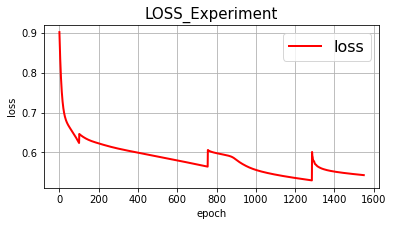

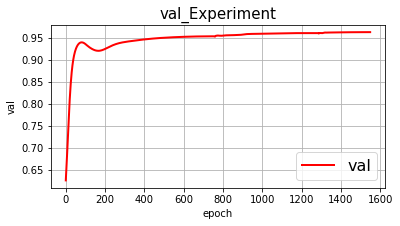

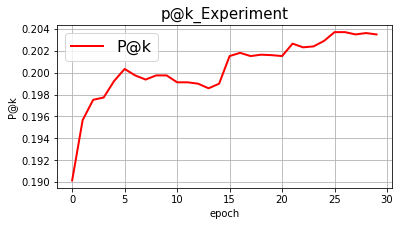

In [35]:
print("-" * 10, "CurLink(GAT)开始训练", "-" * 10)
# 构建网络开始训练
# 构建网络
num_node_features = len(data.x[0])
model = GATNet(num_node_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# 训练
num_epoch = 1000 # 学习epoch数
y_loss = []
y_val_auc = []
P_K_list = []
num_fit = 10
fit_x = np.array([i + 1 for i in range(num_fit)])
epoch_all = 0
for nowDiff in range(NUM_diff_leve):
    # print("*********\n训练新的难度等级\n*********")
    y_tmp_val_auc = []
    
    for epoch in range(1, num_epoch+1):
        epoch_all += 1
        loss = train_diff(data, model, optimizer, nowDiff)
        val_auc = val_diff(data, model, nowDiff)
        if epoch %5 == 0:
            print(f'diffLevel:{nowDiff},Epoch: {epoch:03d},Epoch_all: {epoch_all:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f},')
        y_loss.append(float(loss))
        y_val_auc.append(float(val_auc))
        y_tmp_val_auc.append(float(val_auc))

        # 验证集用来控制何时结束训练,拟合直线斜率小于等于0则停止
        if epoch >100 and len(y_tmp_val_auc) > num_fit:
            fit_y = np.array(y_tmp_val_auc[-num_fit:])
            f1 = np.polyfit(fit_x, fit_y, 1)
            if f1[0] <= 0: break
        
        if epoch_all %50 == 0:
            zzz = model.encode(data.x, data.train_pos_edge_index)
            zzz = zzz[:num_u]
            prob_adj = cosinematrix(zzz)

            K = 10  # topk
            P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
            P_K_list.append(P_K)
            print("精确度：", P_K)
            print("召回率：", R_K)
            print("F1：", F1_)

print("  ")
print("result：")
print("loss:", y_loss[-1])
# print("val_auc:", y_val_auc[-1])
zzz = model.encode(data.x, data.train_pos_edge_index)
zzz = zzz[:num_u]
prob_adj = cosinematrix(zzz)

K = 10  # topk
P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1：", F1_)

x_epoch = [i + 1 for i in range(len(y_val_auc))]
# loss曲线
drawLossVal([i+1 for i in range(len(y_loss))], y_loss, "loss", "LOSS_Experiment", "epoch", "loss")
# auc曲线
drawLossVal(x_epoch, y_val_auc, "val", "val_Experiment", "epoch", "val")
#准确率曲线
drawLossVal([i for i in range(len(P_K_list))], P_K_list, "P@k", "p@k_Experiment", "epoch", "P@k")

# 异构超图+GAT

In [3]:
# 构建训练的data
x_curLink = torch.tensor(np.array(HeterHyper_all_id_vec_list), dtype=torch.float32)  # 先转array再转tensor更快
edge_index_uid = [[], []]
for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
    edge_index_uid[0].append(uid1)
    edge_index_uid[1].append(uid2)
edge_index_uid = torch.tensor(edge_index_uid, dtype=torch.long)

# 把tvc的边放进去
edge_index_uid_tvc = [[], []]
for edge_t in bipG_t.edges():
    # (a,b) a为uid，b为tvc，消息传播方向为 a-b
    edge_index_uid_tvc[0].append(min(edge_t[0], edge_t[1]) - 1)
    edge_index_uid_tvc[1].append(max(edge_t[0], edge_t[1]) - 1)
for edge_v in bipG_v.edges():
    edge_index_uid_tvc[0].append(min(edge_v[0], edge_v[1]) - 1)
    edge_index_uid_tvc[1].append(max(edge_v[0], edge_v[1]) - 1)
for edge_c in bipG_c.edges():
    edge_index_uid_tvc[0].append(min(edge_c[0], edge_c[1]) - 1)
    edge_index_uid_tvc[1].append(max(edge_c[0], edge_c[1]) - 1)
edge_index_uid_tvc = torch.tensor(edge_index_uid_tvc, dtype=torch.long)

data = Data(x=x_curLink, edge_index_uid=edge_index_uid, edge_index_uid_tvc=edge_index_uid_tvc)  # 构建data

# 网络数据放入GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU
# ground_truth_edge_index = data.edge_index_uid.to(device)  # 数据放入GPU
data.edge_index_uid.to(device)  # 数据放入GPU
data.edge_index_uid_tvc.to(device)  # 数据放入GPU
# 样本负采样,测试集验证集分裂,按学习难度分化数据集
data = train_test_split_edges_m(data, num_u, val_ratio=0.05, val_neg_ratio=5)
# data = train_Diff_split_edges(data, node_diffASC_list, NUM_diff_leve)  # 根据学习难度，对边数据进行分级
data = data.to(device)  # 将数据放入device

In [4]:
# 构建网络
num_node_features = len(data.x[0])
model = GATNet(num_node_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

num_epoch = 1500  # 学习epoch数
x_epoch = []
y_loss = []
y_val_auc = []
P_K_list = []
num_fit = 10
fit_x = np.array([i + 1 for i in range(num_fit)])
flag = 1
for epoch in range(1, num_epoch + 1):
    loss = train(data, model, optimizer)
    val_auc = val(data, model)
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}')
    x_epoch.append(epoch)
    y_loss.append(float(loss))
    y_val_auc.append(float(val_auc))

    # 验证集用来控制何时结束训练,拟合直线斜率小于等于0则停止
    if epoch > 500 and len(y_val_auc) > num_fit and flag == 1:
    # if len(y_val_auc) > num_fit:
        fit_y = np.array(y_val_auc[-num_fit:])
        f1 = np.polyfit(fit_x, fit_y, 1)
        if f1[0] <= 0:
            flag = 0
            # break
            print("!!!!!!!!!!!!!!!!!应该停止!!!!!!!!!!!!!!!!!!!!!")
    if epoch % 50 == 0:
        zzz = model.encode(data.x, data.train_pos_edge_index_uWithTvc)
        zzz = zzz[:num_u]
        prob_adj = cosinematrix(zzz)
        
        K = 10
        P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
        print("精确度：", P_K)
        print("召回率：", R_K)
        print("F1_：", F1_)

    # print("result：")
    # print("loss:", y_loss[-1])

zzz = model.encode(data.x, data.train_pos_edge_index_uWithTvc)
zzz = zzz[:num_u]
prob_adj = cosinematrix(zzz)

K = 10
P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1_：", F1_)

# """
# 绘制曲线
# """
# x_epoch = [i + 1 for i in range(len(y_loss))]
# # loss曲线
# drawLossVal(x_epoch, y_loss, "loss", "LOSS_Experiment", "epoch", "loss")
    
# # auc曲线
# drawLossVal(x_epoch, y_val_auc, "val", "val_Experiment", "epoch", "val")

# #准确率曲线
# drawLossVal([i for i in range(len(P_K_list))], P_K_list, "P@k", "p@k_Experiment", "epoch", "P@k")

Epoch: 005, Loss: 0.7007, Val: 0.5690
Epoch: 010, Loss: 0.6932, Val: 0.6270
Epoch: 015, Loss: 0.6888, Val: 0.6805
Epoch: 020, Loss: 0.6862, Val: 0.7226
Epoch: 025, Loss: 0.6844, Val: 0.7501
Epoch: 030, Loss: 0.6830, Val: 0.7674
Epoch: 035, Loss: 0.6819, Val: 0.7775
Epoch: 040, Loss: 0.6809, Val: 0.7839
Epoch: 045, Loss: 0.6799, Val: 0.7883
Epoch: 050, Loss: 0.6788, Val: 0.7923
精确度： 0.1696842105263175
召回率： 0.4981710424506809
F1_： 0.2531439549768062
Epoch: 055, Loss: 0.6777, Val: 0.7963
Epoch: 060, Loss: 0.6765, Val: 0.8004
Epoch: 065, Loss: 0.6752, Val: 0.8042
Epoch: 070, Loss: 0.6739, Val: 0.8072
Epoch: 075, Loss: 0.6724, Val: 0.8099
Epoch: 080, Loss: 0.6709, Val: 0.8123
Epoch: 085, Loss: 0.6694, Val: 0.8148
Epoch: 090, Loss: 0.6678, Val: 0.8169
Epoch: 095, Loss: 0.6662, Val: 0.8189
Epoch: 100, Loss: 0.6646, Val: 0.8206


KeyboardInterrupt: 

# baseline

In [11]:
# # 超二部图结果
# print("-" * 10, "超二部图结果", "-" * 10)
# K = 10
# prob_adj = cosinematrix(torch.tensor(np.array(hyperBip_id_vec_list))) # 先转ndarrays再转tensor更快
# for i in range(len(prob_adj)):
#     prob_adj[i][i] = 0
# P_K, R_K, F1 = count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M)
# print("超二部图_精确度：", P_K)
# print("超二部图_召回率：", R_K)
# print("超二部图_F1：", F1)

# # deepwalk结果
# print("-" * 10, "deepwalk结果", "-" * 10)
# K = 10
# prob_adj = cosinematrix(torch.tensor(np.array(social_id_vec_list)))
# for i in range(len(prob_adj)):
#     prob_adj[i][i] = 0
# P_K, R_K, F1 = count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M)
# print("精确度：", P_K)
# print("召回率：", R_K)
# print("F1：", F1)

# 异构超图结果
print("-" * 10, "异构超图结果", "-" * 10)
K = 10
prob_adj = cosinematrix(torch.tensor(np.array(HeterHyper_id_vec_list)))
# for i in range(len(prob_adj)):
#     prob_adj[i][i] = 0
P_K, R_K, F1 = count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1：", F1)

---------- 异构超图结果 ----------
精确度： 0.37378263284576574
召回率： 0.6248375119309999
F1： 0.46775225100746565
